In [ ]:
!echo 'Mounting...'
from google.colab import drive
drive.mount('/content/drive/')
!ls '/content/drive/My Drive/'
!echo 'Mounted'

(14023, 6, 1) (14023,)
(583, 6, 1) (583,)
Average Test RMSE: 444.613


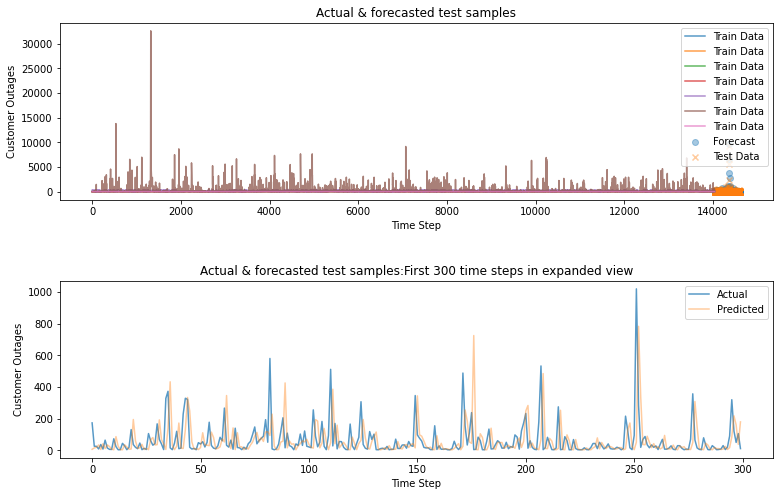

In [ ]:
#@title Persistence Model 
import numpy as np

# Reduce randomness in model outputs
np.random.seed(1)

from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from keras.models import load_model
import pandas as pd
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
from scipy.stats import boxcox
from math import exp
from math import log
from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import array
# %matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sys

np.set_printoptions(threshold=sys.maxsize)

# invert a boxcox transform for one value
def invert_boxcox(value, lam):
  # log case
  if lam == 0:
    return exp(value)
  # all other cases
  return exp(log(lam * value + 1) / lam)

# evaluate a single model
def evaluate_model(n_train_input,n_train_output,n_test_input,n_test_output):
  # history is a list of hourly data
  predictions = list()
  actuals = list()
  for_val = n_train_input[-1]
  predictions.append(for_val[-1])
  actuals.append(n_train_output[-1]) 
      
	# walk-forward validation over each hour
  for i in range(len(n_test_input)):
		# predict the hour    
    yhat_sequence = n_test_input[i]
		# store the predictions   
    predictions.append(yhat_sequence[-1])
		# get real observation and add to history for predicting the next hour
    actuals.append(n_test_output[i])  
  predictions = array(predictions)
  actuals = array(actuals)
  return predictions,actuals
  
#Load county data
mydata = pd.read_csv('/content/drive/My Drive/Images/nassauC.csv', header=0)
dataIn = mydata[mydata.columns[1:8]] 
dateT = mydata[mydata.columns[0]]
dateT = DataFrame(dateT)
dateT['dateTime'] = dateT
dateT.drop('Unnamed: 0', axis = 1, inplace = True)
df_data = pd.concat((dateT, dataIn), axis=1)
df_data = df_data.drop(df_data.columns[0], axis = 1)

# Interpolate missing values
df_data = df_data.interpolate(method ='linear', limit_direction ='both', limit = 10000, axis=0)

# Split into train and test set
train_size = int(len(df_data) * 0.8)
train_data, test_data = df_data[0:train_size], df_data[train_size:]


# Historical data
df_data_train = pd.DataFrame(train_data,columns=['Temp','Preci','Gust','Wind','Windir','LAI','Total Outages'])
# Test data
df_data_test = pd.DataFrame(test_data,columns=['Temp','Preci','Gust','Wind','Windir','LAI','Total Outages'])

# power transform target variable to be gausian like - TRAIN
box_power =df_data_train['Total Outages'] 
transformed, lmbda = boxcox(box_power)  
##df_data_train['Total Outages'] = transformed
df_trans_train = np.array(transformed)
df_trans_train = df_trans_train.reshape(-1,1)

# power transform target variable to be gausian like - TEST
box_power_test =df_data_test['Total Outages'] 
transformed_test = boxcox(box_power_test,lmbda)  
##df_data_test['Total Outages'] = transformed_test
df_trans_test = np.array(transformed_test)
df_trans_test = df_trans_test.reshape(-1,1)

# Smoothed target series peaks with rolling average. This is to reduce noise effect in the data
# Training fold            
dwAvg = 6 # 6hrs rolling average
y_train = pd.DataFrame(df_trans_train)
y_train = y_train.rolling(dwAvg).mean()
y_train = y_train.interpolate(method ='linear', limit_direction ='both', limit = 100, axis=0) 
# Test fold            
y_test = pd.DataFrame(df_trans_test)
y_test = y_test.rolling(dwAvg).mean()
y_test = y_test.interpolate(method ='linear', limit_direction ='both', limit = 100, axis=0)

# Scaling
# Train
Y_scaler = MinMaxScaler(feature_range=(0, 1))
Y_train_scaled_data = Y_scaler.fit_transform(y_train)
# Test
Y_test_scaled_data = Y_scaler.transform(y_test)

# Build history of time series
start = 0  
lag = 6 # look back
h = 6   # horizon
y_tr_input= list()
y_tr_output= list()
train_data_value = Y_train_scaled_data

end = None
start = start + lag
if end is None:
  end = len(Y_train_scaled_data) - h
for i in range(start, end):
  indices = range(i-lag, i)
  y_tra_input = train_data_value[indices]    
  indicey = range(i+1, i+1+h)
  y_tra_output = train_data_value[indicey]
  y_tr_input.append(y_tra_input)
  y_tr_output.append(y_tra_output)


# Prepare test data
start = 0
y_te_input= list()
y_te_output= list()
test_data_value = Y_test_scaled_data

last = None
start = start + lag
if last is None:
  last = len(Y_test_scaled_data) - h
for j in range(start, last, lag):
  indices_j = range(j-lag, j)
  ##print(list(indices_j))
  y_tes_input = test_data_value[indices_j]    
  indicey_j = range(j+1, j+1+h)
  ##print(list(indicey_j))
  y_tes_output = test_data_value[indicey_j]
  y_te_input.append(y_tes_input)
  y_te_output.append(y_tes_output)  

y_train_input = np.array(y_tr_input)
y_test_input = np.array(y_te_input)

y_train_output_reshaped = np.array(y_tr_output)
y_test_output_reshaped = np.array(y_te_output)

y_train_output = y_train_output_reshaped.reshape(y_train_output_reshaped.shape[0],y_train_output_reshaped.shape[1]*1)
y_train_output = y_train_output[:,-1]

y_test_output = y_test_output_reshaped.reshape(y_test_output_reshaped.shape[0],y_test_output_reshaped.shape[1]*1)
y_test_output = y_test_output[:,-1]

# Print input and output smaples
print(y_train_input.shape,y_train_output.shape)
print(y_test_input.shape,y_test_output.shape)

# Compute RMSE
y_pred, y_actual = evaluate_model(y_train_input,y_train_output,y_test_input,y_test_output)
y_p = y_pred.reshape(y_pred.shape[0],1)
y_ac = y_actual.reshape(-1,1)
y_last_h = y_p 
pred_Inverse = Y_scaler.inverse_transform(y_last_h)
# Inverse power transform of forecast values
y_b_inv = [invert_boxcox(x, lmbda) for x in pred_Inverse]
y_b_inv = np.array(y_b_inv)
# Inverse power transform of actual values
actual_Inverse = Y_scaler.inverse_transform(y_ac)
y_actual_inv = [invert_boxcox(x, lmbda) for x in actual_Inverse]
y_actual_inv = np.array(y_actual_inv)

pred = y_b_inv
actual = y_actual_inv[-len(pred):]

mse = mean_squared_error(actual, pred)
# calculate rmse
rmse = sqrt(mse)  
# print rmse
print('Average Test RMSE: %.3f' % (rmse))

# Visualizations
fig, axes = pyplot.subplots(2, 1, figsize=(12, 8))
fig.tight_layout(pad=6.0)

axes[0].set_title("Actual & forecasted test samples")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Customer Outages")

real = DataFrame(actual)
real = real.values

x_axis = np.arange(train_data.shape[0] + pred.shape[0])
axes[0].plot(x_axis[:train_data.shape[0]], train_data, alpha=0.75,label='Train Data')
axes[0].legend(loc="upper right")
axes[0].scatter(x_axis[train_data.shape[0]:], pred, alpha=0.4, marker='o',label='Forecast')
axes[0].legend(loc="upper right")
axes[0].scatter(x_axis[train_data.shape[0]:], actual[-len(pred):], alpha=0.4, marker='x',label='Test Data')
axes[0].legend(loc="upper right")

new_x_axis = np.arange(300)
axes[1].plot(new_x_axis[:real.shape[0]], real[:300], alpha=0.75,label='Actual')
axes[1].legend(loc="upper right")
axes[1].plot(new_x_axis[:real.shape[0]], pred[:300], alpha=0.4,label='Predicted')
axes[1].legend(loc="upper right")
axes[1].set_title("Actual & forecasted test samples:First 300 time steps in expanded view")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("Customer Outages")
pyplot.show()
##fig.savefig('obs_uni_updates_18hrs.png', dpi=300)

actual_1 = DataFrame(actual)
pred_1 = DataFrame(pred)
# Save Outputs
out = concatenate((actual_1,pred_1), axis = 1)
out = DataFrame(out)
out = out.values
output = pd.DataFrame(out,columns=['Actual','Predicted'])
##output.to_csv('/content/drive/My Drive/Colab Notebooks/NAIVE-bron_output48hrs.csv')